## Hyper Tuning model

#### This notebook will do the hypertuning on AdaBoost to get the best score as possible

### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pd.options.display.max_columns = None

from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

random_state=42

### Prepare data

In [2]:
with open('pickle/df_X_train_ct', 'rb') as f:  
    X_train_ct = pickle.load(f)
with open('pickle/df_X_test_ct', 'rb') as f:  
    X_test_ct = pickle.load(f)
with open('pickle/df_y_train', 'rb') as f:  
    y_train = pickle.load(f)
with open('pickle/df_y_test', 'rb') as f:  
    y_test = pickle.load(f)

X_train_ct.shape, X_test_ct.shape, y_train.shape, y_test.shape

((1247, 38), (221, 38), (1247,), (221,))

In [3]:
def confusion_matrix_score(cm, is_print=False):
    tn, fp, fn, tp = cm.ravel()
    acc = (float (tp+tn) / float(tp + tn + fp + fn))
    rcl = (tp / float(tp + fn))
    prc = (tp / float(tp + fp))
    f1 = (2 * rcl * prc) / (rcl + prc)
    if is_print:
        print('tn, fp, fn, tp, acc, rcl, prc, f1 =', tn, fp, fn, tp, acc, rcl, prc, f1)
        print('Accuracy =', np.round(acc, 3), ', Recall =', np.round(rcl, 3), ', Precision =', np.round(prc, 3))
    return tn, fp, fn, tp, acc, rcl, prc, f1

### 1- AdaBoostClassifier Tuning

In [4]:
clf_store = [None]*10
# Got this from: https://stackoverflow.com/questions/6142689/initialising-an-array-of-fixed-size-in-python

In [5]:
model = AdaBoostClassifier(random_state=random_state)
parameters = {      
    'n_estimators':[10,50,250,1000],          
    'learning_rate':[0.01,0.1]
}

clf = GridSearchCV(model, parameters,verbose=3,scoring='f1',n_jobs=-1)
clf.fit(X_train_ct,y_train)
# Got this from: https://stackoverflow.com/questions/32210569/using-gridsearchcv-with-adaboost-and-decisiontreeclassifier

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [10, 50, 250, 1000]},
             scoring='f1', verbose=3)

In [6]:
clf_store[1] = clf

clf.best_score_, clf.best_params_

(0.5000744774938324, {'learning_rate': 0.1, 'n_estimators': 1000})

In [7]:
model = AdaBoostClassifier(learning_rate=0.1, n_estimators=1000)
with open('../streamlit/pickle/ada_2', 'wb') as f:
    pickle.dump(model,f)

In [8]:
cm = confusion_matrix(y_test, clf_store[1].predict(X_test_ct));

In [9]:
tn, fp, fn, tp, acc, rcl, prc, f1 = confusion_matrix_score(cm, True);

tn, fp, fn, tp, acc, rcl, prc, f1 = 184 2 21 14 0.8959276018099548 0.4 0.875 0.5490196078431373
Accuracy = 0.896 , Recall = 0.4 , Precision = 0.875


In [10]:
cm

array([[184,   2],
       [ 21,  14]])

In [11]:
pd.DataFrame(
    [['AdaBoostClassifier', acc, rcl, tn, fp, fn, tp, prc, f1]],
    columns=['model', 'test_accuracy', 'test_recall', 'tn', 'fp', 'fn', 'tp', 'precision', 'f1-score'],
)

,model,test_accuracy,test_recall,tn,fp,fn,tp,precision,f1-score
0,AdaBoostClassifier,0.895928,0.4,184,2,21,14,0.875,0.54902


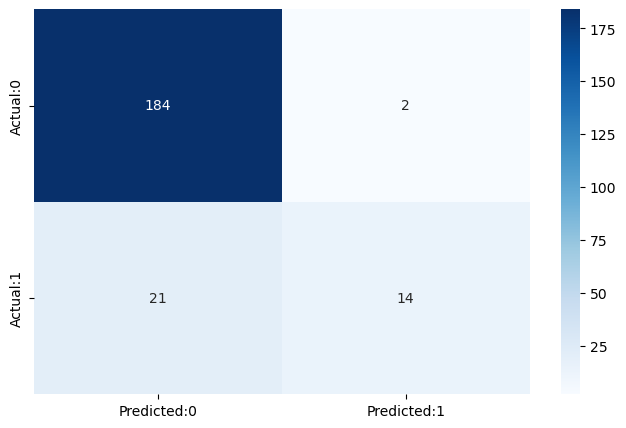

In [12]:
conf_matrix=pd.DataFrame(cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap=plt.cm.Blues);
plt.savefig('../image/ada_best.png')

### 2 - LogisticRegression Tuning

In [13]:
model=LogisticRegression(random_state=random_state)
parameters={
    "C":[0.01, 0.1, 1], 
    "penalty":["l1","l2"] # l1 lasso l2 ridge
}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train_ct,y_train)
# Got this from: https://www.kaggle.com/code/enespolat/grid-search-with-logistic-regression

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", l

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l1', 'l2']})

In [14]:
clf_store[2] = clf
clf.best_score_, clf.best_params_

(0.8853429718875502, {'C': 1, 'penalty': 'l2'})

In [15]:
cm = confusion_matrix(y_test, clf.predict(X_test_ct));

In [16]:
tn, fp, fn, tp, acc, rcl, prc, f1  = confusion_matrix_score(cm, True);

tn, fp, fn, tp, acc, rcl, prc, f1 = 178 8 23 12 0.8597285067873304 0.34285714285714286 0.6 0.43636363636363634
Accuracy = 0.86 , Recall = 0.343 , Precision = 0.6


### 3 - RandomForestClassifier Tuning

In [17]:
model=RandomForestClassifier(random_state=random_state)
parameters={
    'n_estimators':[600],
    'max_depth':[None],
    'min_samples_split':[6,8,10],
    'min_samples_leaf': [2],
    'ccp_alpha':[0, .1, .01],
}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train_ct,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'ccp_alpha': [0, 0.1, 0.01], 'max_depth': [None],
                         'min_samples_leaf': [2],
                         'min_samples_split': [6, 8, 10],
                         'n_estimators': [600]})

In [18]:
clf_store[3] = clf
clf.best_score_, clf.best_params_

(0.8644787148594378,
 {'ccp_alpha': 0,
  'max_depth': None,
  'min_samples_leaf': 2,
  'min_samples_split': 6,
  'n_estimators': 600})

In [19]:
cm = confusion_matrix(y_test, clf.predict(X_test_ct));
tn, fp, fn, tp, acc, rcl, prc, f1 = confusion_matrix_score(cm, True);

tn, fp, fn, tp, acc, rcl, prc, f1 = 183 3 30 5 0.8506787330316742 0.14285714285714285 0.625 0.23255813953488372
Accuracy = 0.851 , Recall = 0.143 , Precision = 0.625


### 4 - KNeighborsClassifier Tuning

In [20]:
model=KNeighborsClassifier()
parameters={'n_neighbors': list(range(1, 31))}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train_ct,y_train)

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]})

In [21]:
clf_store[4] = clf
clf.best_score_, clf.best_params_

(0.8532562248995983, {'n_neighbors': 13})

In [22]:
cm = confusion_matrix(y_test, clf.predict(X_test_ct));

/Users/atigon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [23]:
tn, fp, fn, tp, acc, rcl, prc, f1 = confusion_matrix_score(cm, True);

tn, fp, fn, tp, acc, rcl, prc, f1 = 186 0 33 2 0.8506787330316742 0.05714285714285714 1.0 0.1081081081081081
Accuracy = 0.851 , Recall = 0.057 , Precision = 1.0


### 5 - XGBClassifier Tuning

In [24]:
model = XGBClassifier()
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train_ct,y_train)
# Got this from: https://www.mikulskibartosz.name/xgboost-hyperparameter-tuning-in-python-using-grid-search/

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...e,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=N

In [25]:
clf_store[5] = clf
clf.best_score_, clf.best_params_

(0.8773269076305221,
 {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 180})

In [26]:
cm = confusion_matrix(y_test, clf.predict(X_test_ct));

In [27]:
tn, fp, fn, tp, acc, rcl, prc, f1 = confusion_matrix_score(cm, True);

tn, fp, fn, tp, acc, rcl, prc, f1 = 181 5 24 11 0.8687782805429864 0.3142857142857143 0.6875 0.43137254901960786
Accuracy = 0.869 , Recall = 0.314 , Precision = 0.688


### 6 - SVC

In [28]:
model = SVC()
parameters = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train_ct,y_train)
# Got this from: https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']})

In [29]:
clf_store[6] = clf
clf.best_score_, clf.best_params_

(0.8829365461847389, {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'})

In [30]:
cm = confusion_matrix(y_test, clf.predict(X_test_ct));

In [31]:
tn, fp, fn, tp, acc, rcl, prc, f1 = confusion_matrix_score(cm, True);

tn, fp, fn, tp, acc, rcl, prc, f1 = 182 4 23 12 0.8778280542986425 0.34285714285714286 0.75 0.47058823529411753
Accuracy = 0.878 , Recall = 0.343 , Precision = 0.75


### 7 - StackingClassifier
select model = 1, 5, 6

In [32]:
level_1 = [
    ('model_1', clf_store[1].best_estimator_),
    ('model_5', clf_store[5].best_estimator_),
    ('model_6', clf_store[6].best_estimator_),
]
level_2 = LogisticRegression()

clf = StackingClassifier(estimators=level_1,
                             final_estimator=level_2)
clf.fit(X_train_ct, y_train)

StackingClassifier(estimators=[('model_1',
                                AdaBoostClassifier(learning_rate=0.1,
                                                   n_estimators=1000,
                                                   random_state=42)),
                               ('model_5',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,...
                                              interaction_constrai

In [36]:
cm = confusion_matrix(y_test, clf.predict(X_test_ct));

In [35]:
tn, fp, fn, tp, acc, rcl, prc, f1 = confusion_matrix_score(cm, True);

tn, fp, fn, tp, acc, rcl, prc, f1 = 181 5 21 14 0.8823529411764706 0.4 0.7368421052631579 0.5185185185185185
Accuracy = 0.882 , Recall = 0.4 , Precision = 0.737


### Hyper tuning found 1 interesting model:

Adaboost, increase f1-score to .55, and the precision score spike up to 88%!. It means if someone has beed predicted to leave, the chance of correction is 88% or in 9 leave predicted employee, 8 will be correct.